In [1]:
import sys
import os
from pathlib import Path

notebook_dir = Path.cwd()

project_root = notebook_dir.parent

sys.path.append(str(project_root))

from src.generators.Model import Model

In [2]:
import numpy as np
import torch
from sklearn.cluster import AgglomerativeClustering

from src.generators.Model import Model
from src.generators.config import ModelConfig
from src.testing import TestConfig
from src.testing.clustering.config import ClusterConfig
from src.testing.discriminators import AutoEvaluator
from src.testing.discriminators.config import ProcessorConfig
from src.testing.experiment_functions.plot_result_functions import plot_path_experiment_result
from src.utils.Config import Config
from src.utils.auxiliary_classes.PathTransformer import PathTransformer, PathTransformerConfig
from src.utils.auxiliary_classes.RegimePartitioner import RegimePartitioner, RegimePartitionerConfig
from src.utils.helper_functions.plot_helper_functions import plot_regime_change_path
from src.utils.helper_functions.test_helper_functions import get_memberships, get_sub_paths, get_grouped_paths

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
torch.__version__

'2.6.0+cu118'

In [5]:
test_config             = TestConfig()
cluster_config          = ClusterConfig()
path_transformer_config = PathTransformerConfig()
processor_config        = ProcessorConfig()
model_config            = ModelConfig()
regime_config           = RegimePartitionerConfig()

model_config.year_mesh         = 7*252
model_config.attach_volatility = False

n_steps = 8
n_paths = 16
offset  = 0
T       = 2
dim     = 1
dt      = 1/model_config.year_mesh

S0 = [1. for _ in range(dim)]

test_config.override_args({
    "n_steps": n_steps,
    "n_paths": n_paths,
    "offset" : offset,
    "weight_factor": 1,
    "belief_models": ["gbm"],
    "model_pair_names": ["gbm", "gbm"],
    "belief_params": [[[0., 0.2] for _ in range(dim)]],
    "model_pair_params": [[[0., 0.2] for _ in range(dim)], [[0., 0.3] for _ in range(dim)]],
    "path_bank_size": 100000
})

path_transformer_config.set_transformations({
    "standardise_path_transform":    (True,  0, {"s_type": "initial"}),
    "time_normalisation_transform":  (True,  0, {}),
    "translation_transform":         (True,  0, {}),
    "difference_transform":          (False, 0, {}),
    "squared_log_returns_transform": (False, 0, {}),
    "ewma_volatility_transform"    : (False, 0, {"lambd": 0.5}),
    "cumulant_transform":            (False, 2, {}),
    "increment_transform":           (True, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})

path_transformer_config.compute_pathwise_signature_transform = False
path_transformer_config.signature_order = 8

path_transformer = PathTransformer(path_transformer_config)

processor_config.autoevaluator_kwargs.override_args({
    "metric_kwargs": Config(**{
        "kernel_type": "rbf",
        "metric_type": "mmd",
        "sigmas": [5e-1],  
        "dyadic_orders": [3],  
        "lambd": 1
    })
})

processor_config.device = device

regime_config.override_args({
    "n_regime_changes": 5,
    "f_length_scale"  : 0.5, 
    "type"            : "random_on_off_steps", 
    "r_on_args"       : ["poisson", 4],
    "r_off_args"      : ["poisson", 1/7],
    "r_min_distance"  : 20
})

In [6]:
classifier = AutoEvaluator(
    path_transformer = path_transformer,
    processor_config = processor_config,
    test_config      = test_config
)

Metric initialized. MMD1, kernel = rbf, dyadic_order = 3


In [7]:
regime_partitioner = RegimePartitioner(model_config.year_mesh, regime_config)
regime_partitioner.generate_regime_partitions(T=T, n_steps=n_steps)

model_pair_names, model_pair_params = test_config.model_pair_names, test_config.model_pair_params
model_pairs                         = [Model(name, theta, model_config) for name, theta in zip(model_pair_names, model_pair_params)]

cluster_path = regime_partitioner.generate_regime_change_path(model_pairs, S0)

_, regime_changes, _ = regime_partitioner.changes_to_times()
path_splits_time = [item for sublist in [[r[0], r[1] + 1/model_config.year_mesh] for r in regime_changes] for item in sublist] 
path_splits_mesh = [int(p*model_config.year_mesh) for p in path_splits_time]

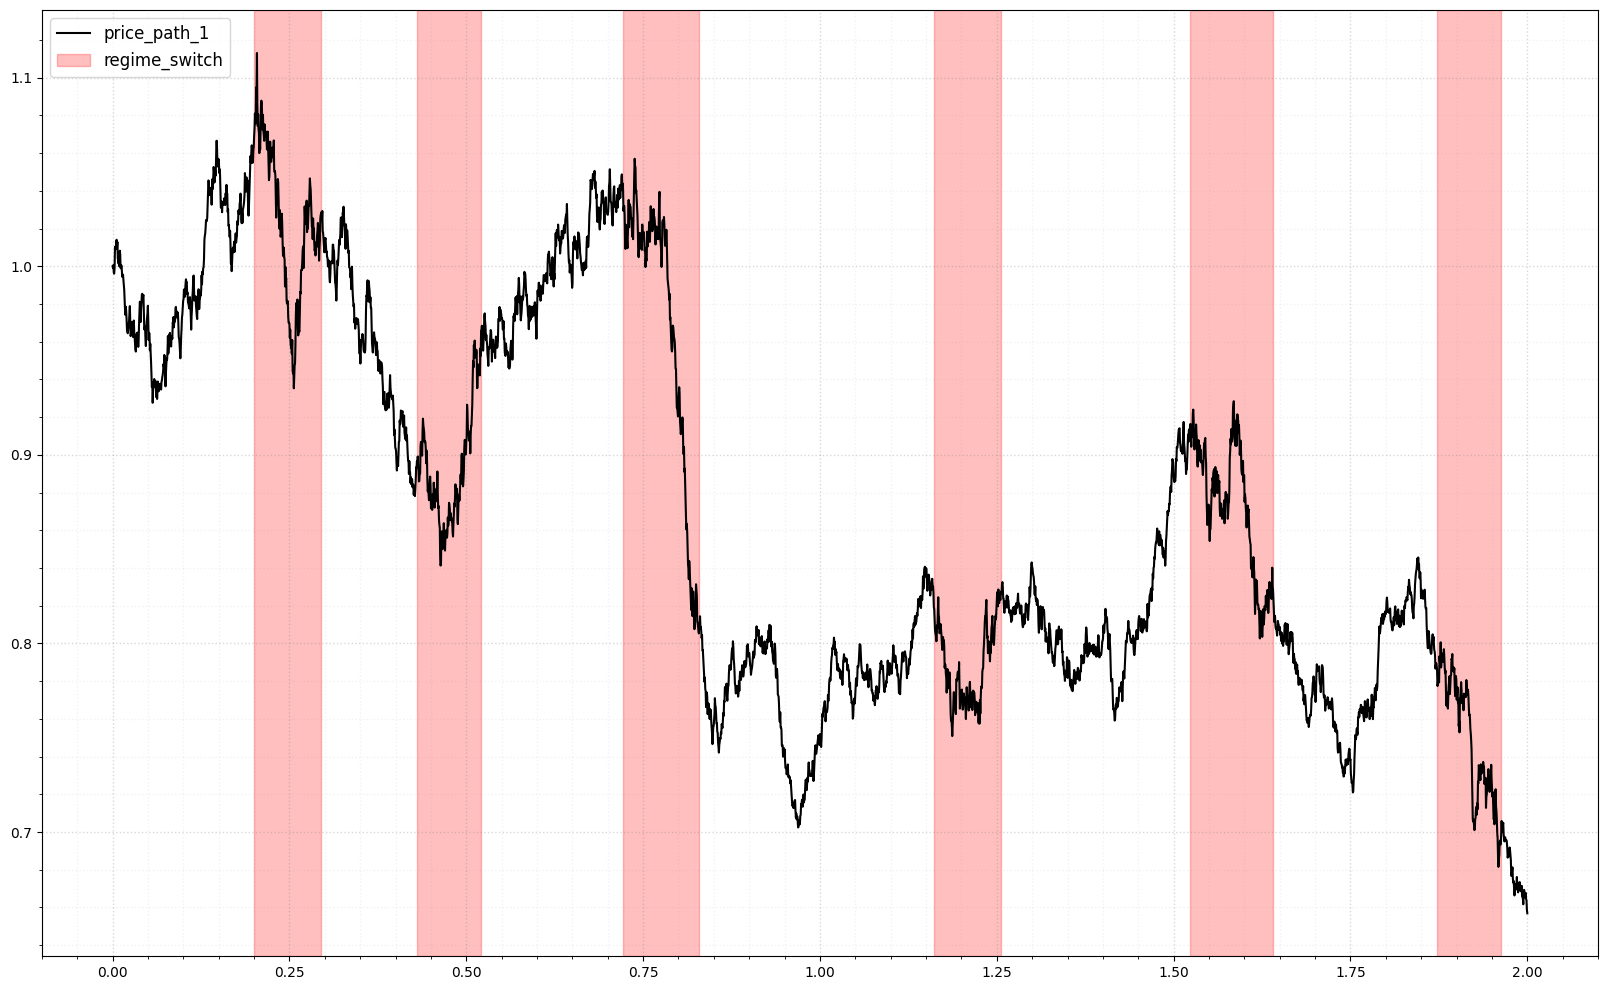

In [8]:
plot_regime_change_path(cluster_path, regime_changes, log_returns=False, one_dim=True)

In [9]:
pairwise_distance_matrix = classifier.generate_distance_matrix(cluster_path)

100%|██████████| 426/426 [7:49:32<00:00, 66.13s/it]     


In [10]:
clusters_object = AgglomerativeClustering(
    n_clusters = 2, 
    metric   = "precomputed", 
    linkage    = "average"
).fit(pairwise_distance_matrix)

labels_ = clusters_object.labels_

In [11]:
sp_cluster = get_sub_paths(cluster_path, n_steps, 0)
mmd_cluster = get_grouped_paths(sp_cluster, n_paths)
sp_cluster_t = path_transformer.transform_paths(sp_cluster.copy())
mmd_cluster_t = get_grouped_paths(sp_cluster_t, n_paths)

100%|██████████| 441/441 [00:00<00:00, 36882.38it/s]


In [12]:
indexes               = sp_cluster[:, -1, 0]
cluster_memberships   = get_memberships(mmd_cluster)

scores                = np.array([np.mean(labels_[m]) for m in cluster_memberships])
cluster_score_array   = np.vstack([indexes, scores])

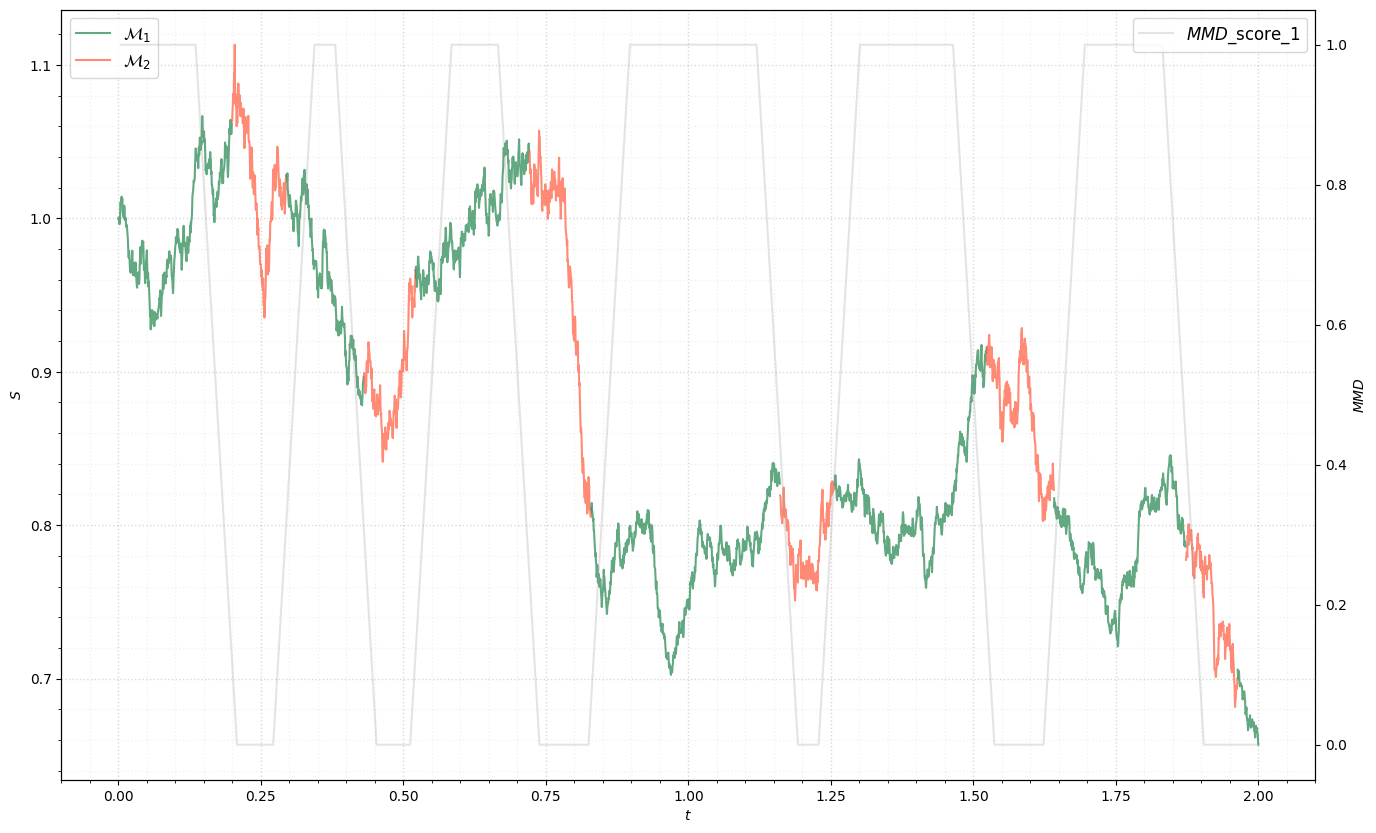

In [13]:
plot_path_experiment_result(cluster_path, cluster_score_array, path_splits_mesh, diff=False, one_dim=True)

In [5]:
import numpy as np
import torch.cuda

from src.generators.config import ModelConfig
from src.testing import TestConfig
from src.testing.discriminators import GeneralMMDDetector
from src.testing.discriminators.config import ProcessorConfig
from src.testing.experiment_functions.mmd_test_functions import alpha_score_function, get_beliefs_from_config
from src.testing.experiment_functions.plot_result_functions import plot_path_experiment_result, plot_path_test_threshold
from src.utils.Config import Config
from src.utils.auxiliary_classes.PathTransformer import PathTransformer, PathTransformerConfig
from src.utils.auxiliary_classes.RegimePartitioner import RegimePartitioner, RegimePartitionerConfig
from src.utils.helper_functions.plot_helper_functions import plot_regime_change_path, plot_scores, plot_beliefs
from src.utils.helper_functions.test_helper_functions import get_memberships, get_alphas, get_sub_paths, \
    get_grouped_paths

np.random.seed(1)

In [ ]:
# Set configs
test_config             = TestConfig()
model_config            = ModelConfig()
path_transformer_config = PathTransformerConfig()
processor_config        = ProcessorConfig()
regime_config           = RegimePartitionerConfig()

## Testing arguments
model_config.override_args({
    "year_mesh": 7*252,          # Grid mesh size (as a fraction of a year), so dt=1/year_mesh
    "attach_volatility": False   # Whether to include the volatility process
})


T   = 4                         # Time to simulate regime-changed path until
dim = 10                        # Dimensionality of simulated paths 
S0  = [1. for _ in range(dim)]  # Initial value of simulated paths
dt  = 1/model_config.year_mesh  # Size of path increment
 
gbm_params_h0 = [0, 0.2]        # \theta = (\mu, \sigma)
gbm_params_h1 = [0, 0.3]        # Same as above

rB_params_h0  = [0.03, 0.5, -0.7, 0.4]  # \theta = (\xi_0, \nu, \rho, H)
rB_params_h1  = [0.03, 0.5, -0.7, 0.3]  # Same as above

belief_params = [[gbm_params_h0 for _ in range(dim)]]
model_pair_params = [[gbm_params_h0 for _ in range(dim)], [gbm_params_h1 for _ in range(dim)]]

test_config.override_args({
    "n_steps": 16,                          # Length of regime paths (h_1)
    "n_paths": 8,                           # Number of paths in an ensemble (h_2)
    "offset" : 0,                           # Deprecated. Parameter that allowed for overlapping paths to be taken
    "weight_factor": 1,                     # Value to make more recent paths more prominent in MMD calculation (larger values).
    "belief_models": ["gbm"],               # Model types for \mathfrak{P} = (\mathfrak{P}_1, \dots, \mathfrak{P}_k)
    "model_pair_names": ["gbm", "gbm"],     # Switching models
    "belief_params": belief_params,         # Parameters associated to beliefs
    "model_pair_params": model_pair_params, # Parameters associated to switching models
    "path_bank_size": 100000                # Number of paths beliefs are comprised of
})

## Path transformation arguments. See the documentation for explicit detail on each transformation.
path_transformer_config.set_transformations({
    "standardise_path_transform":    (True , 0, {"s_type": "initial"}),
    "time_normalisation_transform":  (True , 0, {}),
    "time_difference_transform":     (False, 0, {}),
    "difference_transform":          (False, 0, {}),
    "translation_transform":         (False , 0, {}), 
    "scaling_transform":             (False, 0, {"sigmas": [(1/dt)**0.5 for _ in range(dim)]}),
    "cumulant_transform":            (False , 2, {}),
    "increment_transform":           (True, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})


path_transformer_config.compute_pathwise_signature_transform = False
path_transformer_config.signature_order = 8

## Detector arguments. Again, see the configuration for specific details regarding each parameter. We give some basic ones here
processor_config.override_args({
    "generalmmddetector_kwargs": Config(**{
        "n_tests": 512,                          # Number of atoms in bootstrapped estimate of null distribution of MMDs
        "n_evaluations": 1,                      # When evaluating ensemble paths, number of evaluations of the null MMD
        "metric_kwargs": Config(**{
            "kernel_type": "linear",             # Static kernel type
            "metric_type": "mmd",                # "mmd" or "scoring"
            "sigmas": [2.5e-1],                  # Smoothing hyperparameters. If len(sigmas) == 2, rank 2 MMD is used
            "dyadic_orders": [2],                # Dyadic orders of associated PDE solver. If rank 2 MMD is used, len(dyadic_orders) == 2
            "lambd": 5e-2                        # Regularization parameter for conditional mean embedding
        }),
        "evaluator_kwargs": Config(**{
            "pct_ignore": 0.1
        })
    }),
    "autoevaluator_kwargs": Config(**{
        "metric_kwargs": Config(**{
            "kernel_type": "linear",             # Static kernel type
            "metric_type": "mmd",                # "mmd" or "scoring"
            "sigmas": [2.5e-1],                  # Smoothing hyperparameters. If len(sigmas) == 2, rank 2 MMD is used
            "dyadic_orders": [2],                # Dyadic orders of associated PDE solver. If rank 2 MMD is used, len(dyadic_orders) == 2
            "lambd": 5e-2                        # Regularization parameter for conditional mean embedding
        }),
        "n_scores": 50,                          # Number of scores used to populate the null distribution
        "evaluator_kwargs": Config(**{
            "lags": [-1]                         # Number of lagged ensembles to compare to
        })
    }),
    "alpha_value": 0.95,                         # Confidence threshold
    "device": device,                            # GPU/CPU flag for setting torch tensors
    "overwrite_prior": True                      # Whether to regenerate bootstrapped prior belief distribution, or to use a saved one.
})

## Regime switching arguments
regime_config.override_args({
    "n_regime_changes": 5,                      # Number of regime changes
    "f_length_scale"  : 0.5,                    # If "type" is "fixed_length", fraction of a year regime change persists for
    "type"            : "random_on_off_steps",  # "random_on_off_steps": changes as described in paper. "fixed_length": as above
    "r_on_args"       : ["poisson", 2],         # Z_1 \sim \mathrm{Po}(\lambda_1)
    "r_off_args"      : ["poisson", 1/30],      # Z_2 \sim \mathrm{Po}(\lambda_2)
    "r_min_distance"  : 16,                     # Minimum number of steps of length h_1 regime must persist for
    "r_min_gap"       : 16                      # Minimum number of steps of length h_1 until a new regime can begin.
})

path_transformer = PathTransformer(path_transformer_config)

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
#from fastquant import get_crypto_data
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm

from src.testing import TestConfig
from src.testing.discriminators import AutoEvaluator, GeneralMMDDetector
from src.testing.discriminators.config import ProcessorConfig
from src.testing.experiment_functions.plot_result_functions import plot_path_test_threshold
from src.utils.Config import Config
from src.utils.auxiliary_classes.PathTransformer import PathTransformer, PathTransformerConfig
from src.utils.helper_functions.data_helper_functions import ema
from src.utils.helper_functions.global_helper_functions import get_project_root
from src.utils.helper_functions.plot_helper_functions import make_grid, golden_dimensions
from src.utils.helper_functions.test_helper_functions import get_memberships, get_sub_paths, get_grouped_paths, \
    get_alphas

In [8]:
hmm_data = pd.read_csv("simulated_hmm_2000.csv")

In [9]:
hmm_data.head()

,returns_0,returns_1,returns_2,returns_3,returns_4,returns_5,returns_6,returns_7,returns_8,returns_9,...,states_990,states_991,states_992,states_993,states_994,states_995,states_996,states_997,states_998,states_999
0,0.009437,0.004310,-0.003978,-0.002398,-0.005016,0.004067,0.000366,-0.006666,-0.001476,-0.010636,...,0,0,1,0,0,0,0,1,0,1
1,0.016610,0.011609,-0.013332,0.006140,-0.007961,0.009775,-0.006358,0.005894,0.001101,-0.002425,...,0,0,1,0,0,0,0,1,0,1
2,-0.001539,0.002531,-0.000962,0.001262,0.010211,-0.009533,-0.009993,-0.009177,-0.005534,0.009933,...,0,0,1,0,0,0,0,1,0,1
3,0.011178,0.007041,-0.005691,-0.006794,0.006150,0.011354,-0.014519,0.011199,-0.005432,0.011723,...,0,0,1,0,0,0,0,1,0,1
4,0.009228,-0.013830,-0.008754,-0.000595,0.029544,0.010097,0.013713,0.004408,0.001279,0.001886,...,0,0,1,0,0,0,0,1,0,1


In [10]:
hmm_label = hmm_data.iloc[:,1000:2001]
hmm_label

,states_0,states_1,states_2,states_3,states_4,states_5,states_6,states_7,states_8,states_9,...,states_990,states_991,states_992,states_993,states_994,states_995,states_996,states_997,states_998,states_999
0,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
1,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
2,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
3,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
4,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [52]:
hmm_label['states_117'] == 0

0      True
1      True
2      True
3      True
4      True
       ... 
995    True
996    True
997    True
998    True
999    True
Name: states_117, Length: 1000, dtype: bool

In [11]:
hmm_data = hmm_data.iloc[:,0:1000]
hmm_data

,returns_0,returns_1,returns_2,returns_3,returns_4,returns_5,returns_6,returns_7,returns_8,returns_9,...,returns_990,returns_991,returns_992,returns_993,returns_994,returns_995,returns_996,returns_997,returns_998,returns_999
0,0.009437,0.004310,-0.003978,-0.002398,-0.005016,0.004067,0.000366,-0.006666,-0.001476,-0.010636,...,0.001992,0.001963,0.013986,0.001536,0.016131,-0.000250,-0.010867,-0.004825,-0.010755,-0.012548
1,0.016610,0.011609,-0.013332,0.006140,-0.007961,0.009775,-0.006358,0.005894,0.001101,-0.002425,...,0.012799,-0.003893,-0.017047,0.005310,0.006582,0.003146,0.009231,0.009418,-0.004603,-0.014208
2,-0.001539,0.002531,-0.000962,0.001262,0.010211,-0.009533,-0.009993,-0.009177,-0.005534,0.009933,...,0.004987,0.004663,0.006953,-0.003134,0.011758,-0.003289,0.015381,-0.001888,0.005007,0.029506
3,0.011178,0.007041,-0.005691,-0.006794,0.006150,0.011354,-0.014519,0.011199,-0.005432,0.011723,...,0.001377,0.007551,-0.011601,0.007099,0.010996,-0.001070,-0.004325,0.010346,-0.000605,0.020650
4,0.009228,-0.013830,-0.008754,-0.000595,0.029544,0.010097,0.013713,0.004408,0.001279,0.001886,...,0.000366,-0.009018,0.018947,-0.000206,0.000685,0.013673,0.009245,0.027451,0.009414,0.005287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.009472,0.004150,-0.006217,0.006383,-0.001495,-0.008091,0.002350,-0.004923,-0.000813,-0.001152,...,-0.003800,0.016004,-0.007721,0.005909,0.007668,-0.007390,0.003075,-0.000770,0.001392,-0.006780
996,0.012264,-0.007704,-0.001233,0.003316,-0.000927,-0.003855,-0.000088,0.003227,-0.009474,0.003495,...,-0.010568,-0.012951,0.003323,0.015016,0.022310,-0.001589,-0.001257,-0.003780,-0.000727,-0.005204
997,0.001011,-0.001713,-0.001159,-0.009368,0.001427,0.007342,-0.002741,-0.023399,-0.003341,-0.000796,...,-0.004665,-0.041161,0.004988,0.007734,0.001843,-0.009087,-0.000452,-0.013742,-0.005294,-0.012856
998,0.006874,-0.009633,-0.005173,0.002841,0.013051,0.013826,-0.003284,-0.001109,0.002547,0.002817,...,-0.009187,-0.010975,-0.010790,0.000843,0.004981,0.001431,-0.015291,-0.002365,0.005788,0.000155


In [13]:
np_hmm_data = hmm_data.copy().to_numpy()

In [45]:
hmm_data.index.to_numpy()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [33]:
cluster_path_real        = np.zeros((hmm_data.shape[0], 2))
cluster_path_real[:, 1:] = hmm_data[['returns_117']].to_numpy()
cluster_path_real[:, 0]  = hmm_data.index.to_numpy()

snp_plot                 = np.zeros((hmm_data.shape[0], 2))
snp_plot[:, 0]           = hmm_data.index.to_numpy()
snp_plot[:, 1]           = hmm_data[['returns_117']].to_numpy()[:, -1] ##might be false

In [74]:
path_transformer_config = PathTransformerConfig()

dt = 1/1000  # Approximately

path_transformer_config.set_transformations({
    "standardise_path_transform":    (True,  0, {"s_type": "initial"}),
    "time_difference_transform":     (False, 0, {}),
    "time_normalisation_transform":  (True,  0, {}),
    "difference_transform":          (False, 0, {}),
    "translation_transform":         (False, 0, {}), 
    "scaling_transform":             (False, 0, {"sigmas": [dt**-0.5 for _ in range(len(hmm_label))]}),
    "cumulant_transform":            (False, 2, {}),
    "increment_transform":           (False, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})

offset  = 0
n_steps = 8
n_paths = 8

real_test_config = TestConfig()
real_test_config.n_steps = n_steps
real_test_config.n_paths = n_paths
real_test_config.offset  = offset

n_steps_real = real_test_config.n_steps
n_paths_real = real_test_config.n_paths

pt          = PathTransformer(path_transformer_config)
sp_real     = get_sub_paths(cluster_path_real, n_steps, offset)
snp_sp_real = get_sub_paths(snp_plot, n_steps, offset)
mmd_real    = get_grouped_paths(sp_real, n_paths)
sp_t_real   = pt.transform_paths(sp_real.copy())
mmd_t_real  = get_grouped_paths(sp_t_real, n_paths)

100%|██████████| 125/125 [00:00<00:00, 31203.90it/s]


In [84]:
processor_config = ProcessorConfig()

processor_config.override_args({
   "autoevaluator_kwargs": Config(**{
        "metric_kwargs": Config(**{
            "kernel_type": "rbf",
            "metric_type": "mmd",
            "sigmas": [1],
            "dyadic_orders": [2],
            "lambd": 1
        }),
        "n_scores": 5,
        "evaluator_kwargs": Config(**{
            "lags" : [-4, -8, -12],
            "threshold_method": "bootstrap",
        })
    })
})

processor_config.alpha_value = 0.95

auto_evaluator = AutoEvaluator(
    path_transformer = pt,
    processor_config = processor_config,
    test_config      = real_test_config
)

Metric initialized. MMD1, kernel = rbf, dyadic_order = 2


In [85]:
real_data_scores = auto_evaluator.evaluate_path(cluster_path_real)

real_indexes_ = real_data_scores[0, :]
real_scores_  = real_data_scores[1, :]
real_alphas_  = real_data_scores[2, :]

100%|██████████| 106/106 [00:01<00:00, 58.58it/s]


IndexError: index 5 is out of bounds for axis 1 with size 2

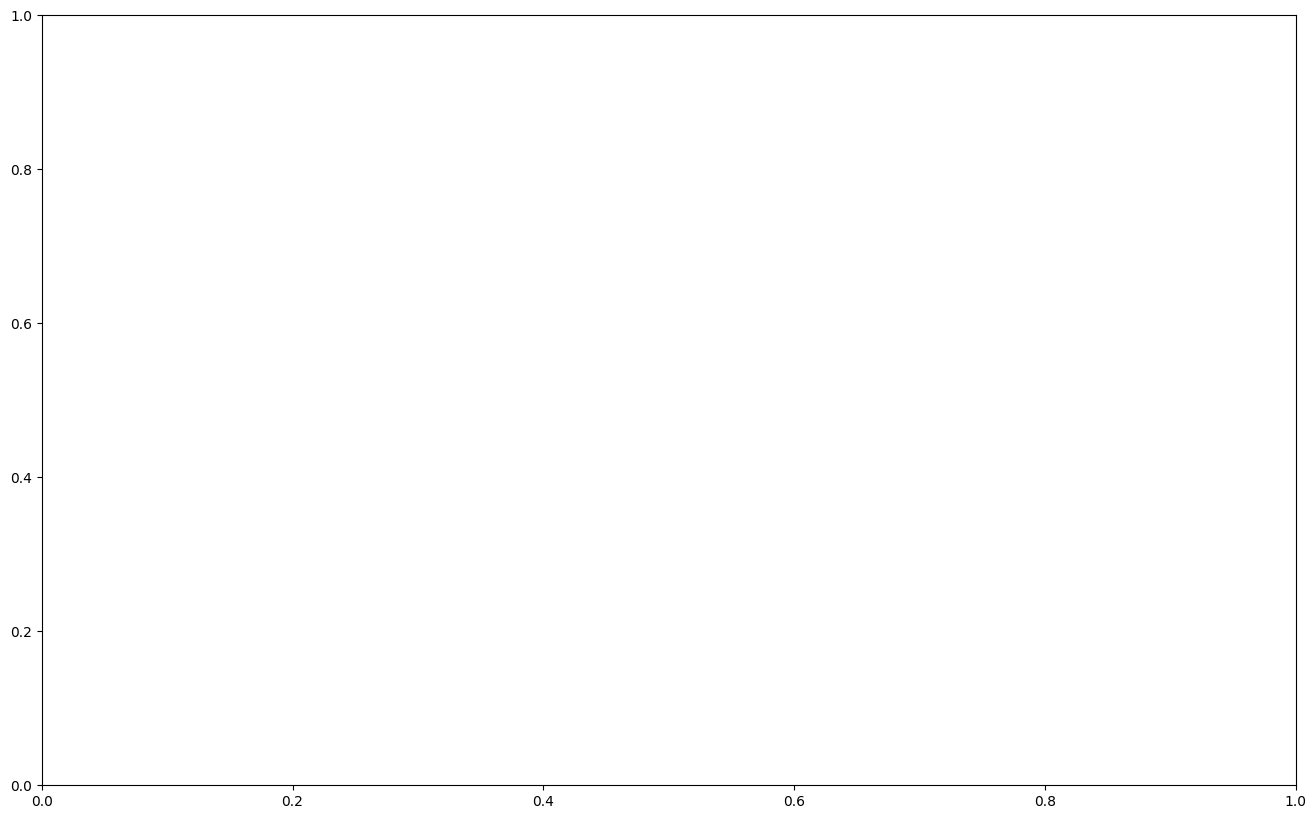

In [86]:
matplotlib.rc_file_defaults()

width = 10
price_indexes  = cluster_path_real[:, 0]
score_indexes  = real_indexes_
to = int(0.10*price_indexes.shape[0])

ind = 5

k = real_test_config.n_paths

plt.figure(figsize=golden_dimensions(width))
ax = plt.gca()

ax.plot(price_indexes, cluster_path_real[:, ind], color='black', alpha=0.4, label=tickers[ind-1])
ax2 = ax.twinx()
ax2.plot(score_indexes, real_scores_, color="dodgerblue", linestyle="dashed", alpha=0.25, label="auto_evaluator_score")
#ax2.plot(score_indexes, real_alphas_, color="tomato", alpha=0.25, label="crit_thresh")
ax2.plot(score_indexes[k-1:], ema(real_scores_, k), color="dodgerblue", alpha=0.75, label="ema({})_ae_score".format(k))
make_grid()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
ax2.legend(loc="upper right", prop={'size': 12});
plt.xticks(price_indexes[to::2*to], list(map(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'), price_indexes[to::2*to])))
plt.show()

In [87]:
num_paths              = mmd_t_real.shape[0]
res                    = np.zeros((num_paths, num_paths))
generate_pairwise_data = True

if generate_pairwise_data:
    for i in tqdm(range(num_paths)):
        path_i = mmd_t_real[i]
        for j in range(i, num_paths):
            path_j = mmd_t_real[j]
            score = auto_evaluator.metric(path_i, path_j)
            res[i, j] = score
            if i != j:
                res[j, i] = score
    np.save(get_project_root().as_posix() + "/data/real_data_pw_distances.npy", res, allow_pickle=True)
else:
    try:
        res = np.load(get_project_root().as_posix() + "/data/real_data_pw_distances.npy", allow_pickle=True)
    except FileNotFoundError:
        print("Pairwise data matrix has not been generated yet. Please generate pairwise distances first.")

100%|██████████| 118/118 [00:48<00:00,  2.43it/s]


In [98]:
n_clusters = 2

clusters_real = AgglomerativeClustering(
    n_clusters = n_clusters, 
    metric   = "precomputed", 
    linkage    = "complete"
).fit(res)

In [99]:
# Transform labels so the earlier clusters have fewer elements
from collections import Counter

def rank_unique_elements(lst):
    # Count the occurrences of each element
    counts = Counter(lst)

    # Sort the unique elements based on their counts in descending order
    ranked_elements = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    # Extract the unique elements from the ranked list
    unique_elements = [item[0] for item in ranked_elements]

    return unique_elements

ranks = rank_unique_elements(clusters_real.labels_)
rank_dict = {r: i for i, r in enumerate(ranks)}
labels_real = [rank_dict[l] for l in clusters_real.labels_]

In [100]:
indexes_real = mmd_real[:, -1, -1, 0]
scores_real  = np.array(labels_real)
cluster_score_array_real = np.c_[indexes_real, scores_real]

In [101]:
# Get average membership for each sub-path
real_memberships      = get_memberships(mmd_real)
average_cluster_score = np.array([np.mean(scores_real[ind]) for ind in real_memberships])
average_indexes       = sp_real[:, -1, 0]

unique_scores = np.unique(average_cluster_score)
n_colors      = np.unique(average_cluster_score).shape[0]
cmap          = sns.diverging_palette(133, 20, l=60, n=n_colors, center="light")

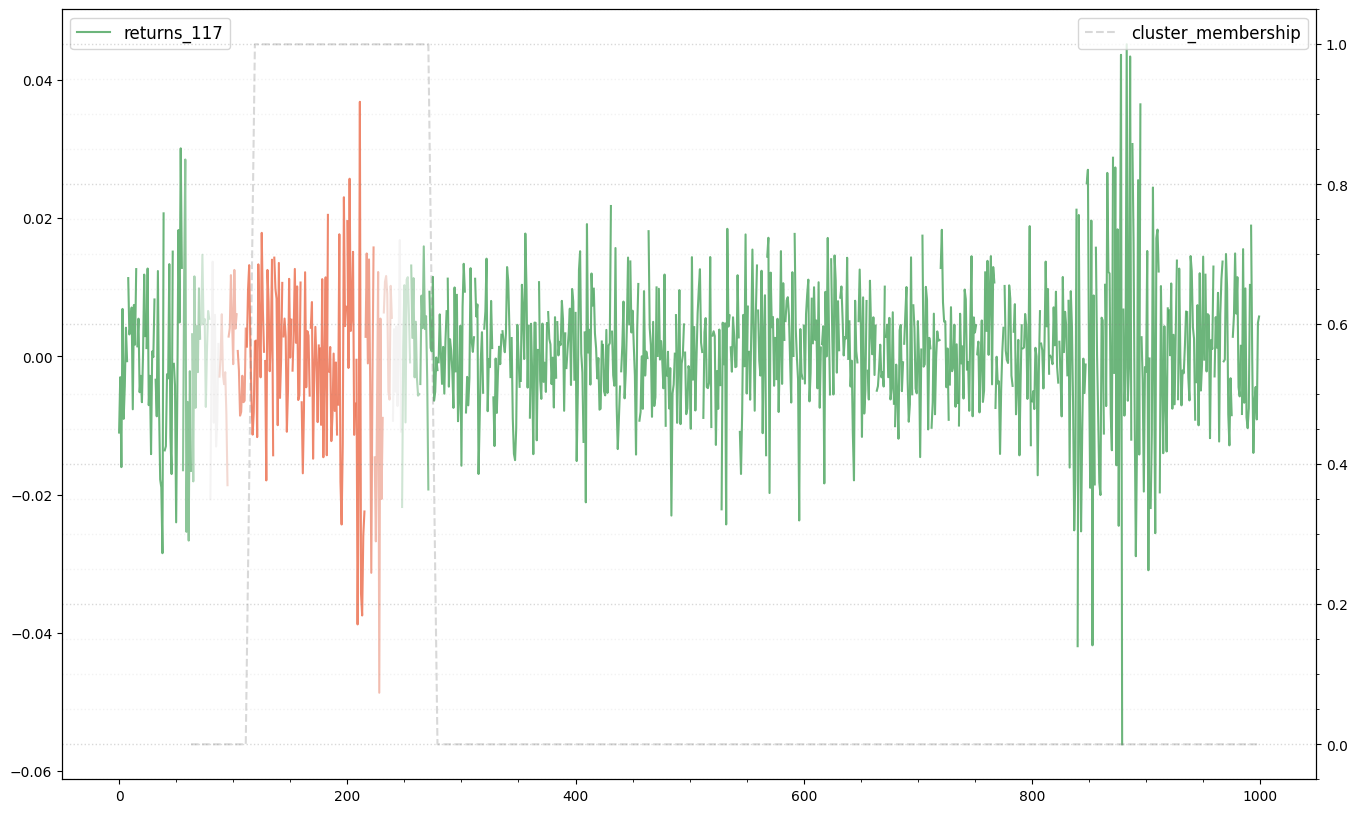

In [102]:
price_indexes   = [pd.Timestamp(x) for x in cluster_path_real[:, 0]]
#score_indexes   = [pd.Timestamp(x) for x in indexes_real]
score_indexes = indexes_real
average_indexes = [pd.Timestamp(x) for x in average_indexes]
k=10

width = 10
plt.figure(figsize=golden_dimensions(width))
ax = plt.gca()
for i, s in enumerate(sp_real):
    #indexes = [pd.Timestamp(x) for x in s[:, 0]]
    indexes = s[:, 0]
    color = cmap[int(np.argwhere(average_cluster_score[i] == unique_scores)[0][0])]
    ax.plot(indexes, s[:, -1], color=color, alpha=0.8, label="returns_117")
ax2 = ax.twinx()
ax2.plot(score_indexes, scores_real, color='grey', alpha=0.3, label="cluster_membership", linestyle='dashed')
make_grid()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
ax2.legend(loc="upper right", prop={'size': 12});

In [57]:
regime_change_117 = hmm_label.index[hmm_label['states_117'] == 1].tolist()

In [62]:
regime_change_117 = pd.DataFrame(regime_change_117)
regime_change_117.to_csv('117')